<a href="https://colab.research.google.com/github/govindramesh/segment-anything/blob/main/notebooks/Fine_Tuning_SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install torch torchvision torchmetrics &> /dev/null
! pip install matplotlib &> /dev/null
! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth &> /dev/null

In [12]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

In [3]:
%cd /home/govind/segment-anything-1

/home/govind/segment-anything-1


In [4]:
from segment_anything import SamPredictor, sam_model_registry
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import torch
import os

In [5]:
checkpoint = 'sam_vit_b_01ec64.pth'
sam = sam_model_registry['vit_b'](checkpoint=checkpoint)
predictor = SamPredictor(sam)


In [6]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, mask_dir):
        self.root_dir = root_dir
        self.mask_dir = mask_dir
        self.images = os.listdir(self.root_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.images[idx])
        mask_name = os.path.join(self.mask_dir, self.images[idx][:3]+"_label.PNG")

        image = np.asarray(Image.open(img_name))
        mask = np.asarray(Image.open(mask_name))

        return image, mask

In [7]:
# Load custom dataset
dataset = CustomDataset(root_dir='data/Images', mask_dir='data/Masks')

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [8]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [100, 18])

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
predictor.model.to(device)
predictor.model.train()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [10]:
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([60]).to(device))

optimizer = torch.optim.Adam(predictor.model.mask_decoder.parameters(), lr=.0001)


In [11]:
for name, param in predictor.model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)
  else:
    param.requires_grad_(True)

In [14]:
for epoch in range(10):
    predictor.model.train(True)
    training_loss = 0.0
    for i, data in tqdm(enumerate(train_dataloader, 0), total=len(train_dataloader)):
        inputs, labels = data
        labels = labels.to(device)/255

        inputs = inputs.to(device)

        optimizer.zero_grad()

        predictor.set_image(np.asarray(inputs[0].cpu()))
        masks, scores, logits = predictor.predict(
            multimask_output=False,
            return_logits=True
        )

        loss = criterion(masks[0], labels.float())
        loss.backward()
        optimizer.step()

        training_loss += loss.item()

    predictor.model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_dataloader, 0), total=len(test_dataloader)):
            inputs, labels = data
            labels = labels.to(device)/255

            inputs = inputs.to(device)

            predictor.set_image(np.asarray(inputs[0].cpu()))
            masks, scores, logits = predictor.predict(
                multimask_output=False,
                return_logits=True
            )
            
            loss = criterion(masks[0], labels.float())
            test_loss += loss.item()

    print(f"EPOCH {epoch+1}")
    print(f"TRAINING LOSS: {training_loss/len(train_dataloader)}")
    print(f"TEST LOSS: {test_loss/len(test_dataloader)}")
    timestr = time.strftime("%m%d-%H%M%S")
    torch.save(predictor.model.state_dict(), f"model_checkpoints/{timestr}_epoch_{epoch+1}.pth")

print('Finished Training')

100%|██████████| 18/18 [00:03<00:00,  5.95it/s]


EPOCH 1
TRAINING LOSS: 0.41817413792014124
TEST LOSS: 0.47665608177582425


100%|██████████| 18/18 [00:03<00:00,  5.89it/s]


EPOCH 2
TRAINING LOSS: 0.38399449951946735
TEST LOSS: 0.39432243754466373


100%|██████████| 18/18 [00:03<00:00,  5.83it/s]


EPOCH 3
TRAINING LOSS: 0.3411138352006674
TEST LOSS: 0.3900178227987554


100%|██████████| 18/18 [00:03<00:00,  5.85it/s]


EPOCH 4
TRAINING LOSS: 0.3201556007564068
TEST LOSS: 0.4100620531373554


100%|██████████| 18/18 [00:03<00:00,  5.84it/s]


EPOCH 5
TRAINING LOSS: 0.33551817789673805
TEST LOSS: 0.42101497534248566


100%|██████████| 18/18 [00:03<00:00,  5.83it/s]


EPOCH 6
TRAINING LOSS: 0.3380227070301771
TEST LOSS: 0.3885518109632863


100%|██████████| 18/18 [00:03<00:00,  5.84it/s]


EPOCH 7
TRAINING LOSS: 0.29963690735399723
TEST LOSS: 0.37829450600677067


100%|██████████| 18/18 [00:03<00:00,  5.84it/s]


EPOCH 8
TRAINING LOSS: 0.29191396713256834
TEST LOSS: 0.41067512043648297


100%|██████████| 18/18 [00:03<00:00,  5.82it/s]


EPOCH 9
TRAINING LOSS: 0.27969157695770264
TEST LOSS: 0.418233507209354


100%|██████████| 18/18 [00:03<00:00,  5.83it/s]


EPOCH 10
TRAINING LOSS: 0.2713017358630896
TEST LOSS: 0.4068668824103143
Finished Training


In [ ]:
plt.figure(figsize=(3,3))
label = np.asarray(mask.squeeze().detach().cpu())
plt.imshow(label)

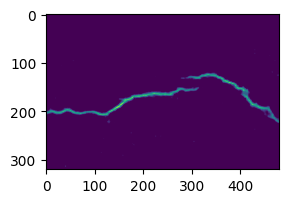

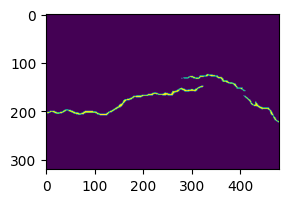

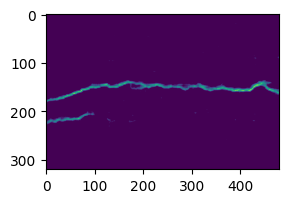

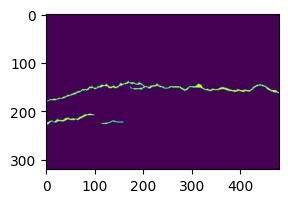

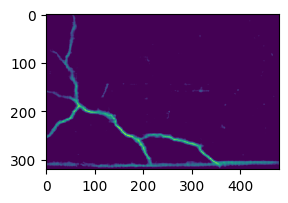

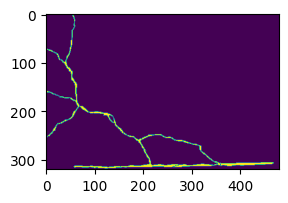

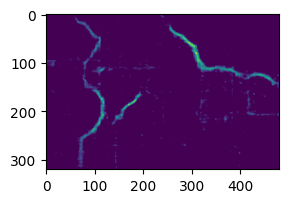

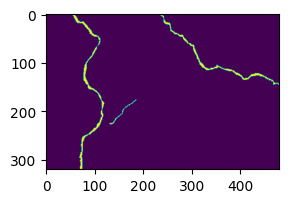

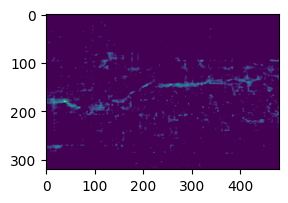

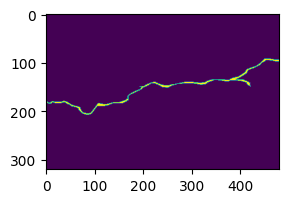

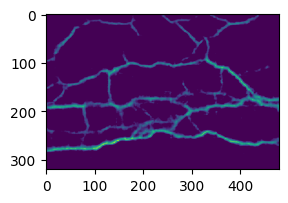

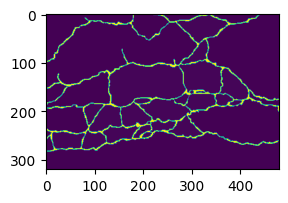

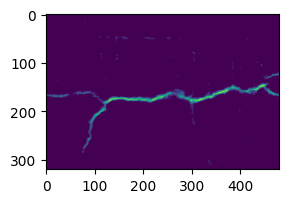

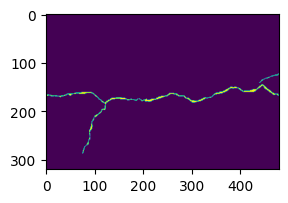

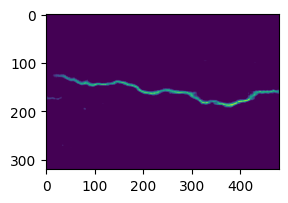

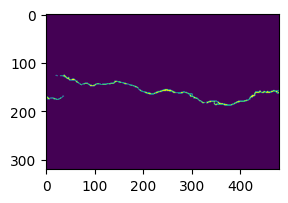

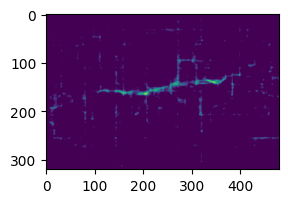

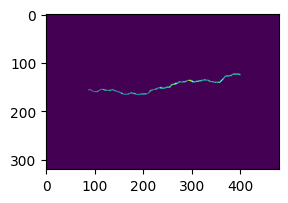

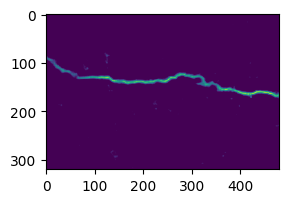

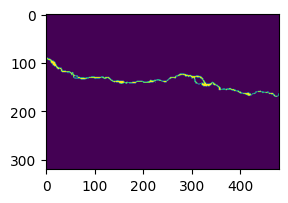

In [13]:
for i in range(10):
    with torch.no_grad():
        item = test_dataset.__getitem__(i)[0]
        predictor.set_image(item)
        mask, score, logit = predictor.predict(
            multimask_output=False,
            return_logits=True
        )

    mask[mask < 0] = 0
    plt.figure(figsize=(3,3))
    output = np.asarray(mask.squeeze().detach().cpu())
    plt.imshow(output)
    plt.figure(figsize=(3,3))
    label = np.asarray(test_dataset.__getitem__(i)[1])
    plt.imshow(label)

In [ ]:
params = []
for param in predictor.model.mask_decoder.parameters():
    params.append(param.view(-1))
params = torch.cat(params)
print(params.shape)
params[0:10]

In [16]:
image = np.asarray(Image.open("road.jpeg"))


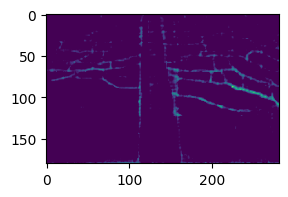

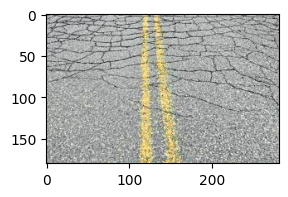

In [17]:
with torch.no_grad():
    predictor.set_image(image)
    mask, score, logit = predictor.predict(
        multimask_output=False,
        return_logits=True
    )

    mask[mask < 0] = 0
    plt.figure(figsize=(3,3))
    output = np.asarray(mask.squeeze().detach().cpu())
    plt.imshow(output)
    plt.figure(figsize=(3,3))
    plt.imshow(image)